In [ ]:
# at the moment, only tested here: http://localhost:7261/lab/tree/GlacierMIP3/2023_exploratory_analysis_notebooks/per_glacier_lowess_calib/trials.ipynb
## **This has been updated to 0.69°C...**

fit_to_per_glacier_models = True

show_median = False

fit_to_median=False # False


approach = '_via_5yravg'

# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Feb12_2024' #'apr04' (has OGGM runaway effect of glaciers inside)
fill_option = 'repeat_last_101yrs' #'repeat_last_20yrs'
avg_over = 101
add_lowess=True
#avg_over = '100yr'
temp_ch = '' #'regional_glacier'
shift_years = True
temp_above_0_8_sel = False

ipcc_ar6 = True
# add that index to the saved figures and files
if ipcc_ar6:
    t_add = '_ipcc_ar6'
else:
    t_add = ''

sim_years = [5000] #,50,100,300,500] #100, 300, 500, 

qs = [0.5] #[0.05,0.25,0.5,0.75,0.95]

N = 500 # just to be sure ... 150#50 #200#50 #500 #100 #100 #100 #100#100
it = 2 #2#2
rgi_regs_global = ['All','01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19']
write_exp_text = True


import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from moepy import lowess, eda

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
f_path_data ='/home/users/lschuster/GlacierMIP3/'

f_path ='/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/per_glacier_lowess_calib/'
f_path_f = '/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/figures/2a_lowess_fits/'

try:
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

    # --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
if ipcc_ar6:
    pd_global_temp_exp = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)
else:
    pd_global_temp_exp = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_isimip3b.csv', index_col = 0)
if ipcc_ar6:
    pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)
else:
    pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

def get_glob_temp_exp(region='global'):
    if ipcc_ar6:
        pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)
    else:
        pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    #print(_p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc'))
    _p = _p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc')
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)



from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous

hue_order_anonymous = []
pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
        hue_order.append(m)
        pal_models_l.append(p)
        
        
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

pal_models = pal_models_l
pal_models = sns.color_palette(pal_models)


dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
ds_reg_models = ds_reg_models.sel(model_author=hue_order)

ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])


ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


import matplotlib
matplotlib.__version__

pd_rgi_stats_w_hugonnet = pd.read_csv(f'/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv', index_col = [0])

ds_reg_yr_shift= xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')
ds_reg_yr_shift_vol = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3
ds_reg_yr_shift_vol_med = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3.median(dim='model_author')
ds_reg_yr_shift = ds_reg_yr_shift.sel(model_author = hue_order)

show_color_models = True
plt.rc('font', size=24)  


# option A: choose 20-year period before and do the average!
import numpy as np
from scipy.optimize import curve_fit

#sim_year = 5000
# Define the exponential decay function, want to ensure that it -> zero if temperature is large!!!


#rgi_regs_global = ['03']# 
current_deltaT = 1.2

if shift_years:
    p_shift = '_shift_years_rel_2020'
else:
    p_shift = ''


    
for temp_above_0_8 in [temp_above_0_8_sel]: #,False]: True

    for version in ['simple']:
        jj=0
        if version == 'simple':
            def exponential_decay(x, a, b):
                # avoind overflow -> does not work ... 
                exp_values = -b * x
                #exp_values = np.clip(exp_values, -709, 709)  # Clip values to avoid overflow
                return a * np.exp(exp_values) #+ c * np.exp(-d * x**2)#**c 
            param_bounds = ([0, 0], [1000, 5])
            pd_exp_decay_fits_simple = pd.DataFrame(index=np.arange(0,20*8,1), #4
                                                    columns=['rgi_reg','year',
                                                             'a_simple', 'b_simple', 'model_author'])

        else:
            def exponential_decay(x, a, b,c,d):
                exp_values_b = -b * x
                #exp_values_b = np.clip(exp_values_b, -709, 709)  # Clip values to avoid overflow

                exp_values_d = -d * x**2
                #exp_values_d = np.clip(exp_values_d, -709, 709)  # Clip values to avoid overflow
                return a * np.exp(exp_values_b) + c * np.exp(exp_values_d)#**c 
            param_bounds = ([0, 0,0,0], [1000, 5,1000, 5])
            pd_exp_decay_fits_adv = pd.DataFrame(index=np.arange(0,20*8,1), #4
                                                 columns=['rgi_reg','year',
                                                          'a_comp', 'b_comp',
                                                          'c_comp', 'd_comp', 'model_author'])

        for sim_year in sim_years: # 
            if sim_year <5000:
                avg_over = '20yr'
            else:
                avg_over = '101yr'
            if temp_above_0_8:
                add= '_temp_above_0_8'
            else:
                add = ''
    
            if sim_year==5000:
                v_n = r'$V_{\%,ss}$'
                state = 'Steady-state volume'
            elif sim_year == 50:
                v_n = r'$V_{\%,50yr}$'
                state = 'Volume after 50 years'
            elif sim_year == 100:
                v_n = r'$V_{\%,100yr}$'
                state = 'Volume after 100 years'
            elif sim_year == 300:
                v_n = r'$V_{\%,300yr}$'
                state = 'Volume after 300 years'
            elif sim_year ==500:
                v_n = r'$V_{\%,500yr}$'
                state = 'Volume after 500 years'
            if avg_over=='101yr':
                sim_year_avg = 101
            elif avg_over=='60yr':
                sim_year_avg = 60
            else:
                sim_year_avg = 20
            fig, axs = plt.subplots(5,4,figsize=(35,40), sharey=True) #, sharey='row') #, sharex=True)
            if shift_years:
                ds_reg_models_med_vol_roll = ds_reg_yr_shift_vol_med.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
                ds_reg_models_vol_roll = ds_reg_yr_shift_vol.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
            else:
                ds_reg_models_med_vol_roll = ds_reg_models_med_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
                ds_reg_models_vol_roll = ds_reg_models_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
            
            df_quantiles_l = []
            sel_l = []
            for j, rgi_reg in enumerate(rgi_regs_global):
                if rgi_reg == 'All':
                    _rgi_reg = 'Globally'
                else:
                    _rgi_reg = rgi_reg
                vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[_rgi_reg][f'regional_volume_m3_2020{approach}']

                if j<4:
                    ax = axs[0][j]
                elif j <8:
                    ax = axs[1][j-4]
                elif j <12:
                    ax = axs[2][j-8]
                elif j <16:
                    ax = axs[3][j-12]
                elif j <20:
                    ax = axs[4][j-16]
                    
                region = f'RGI{rgi_reg}_glacier'

                if rgi_reg == 'All':
                    # get the temp.
                    if temp_ch != 'regional_glacier':
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global')
                    else:
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global_glacier')
                    if shift_years:
                        # we have done the dropping of everything after 4950, so the last year should be fine 
                        ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')
                        # make sure that we only take here global models ... 
                        ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(year_after_2020=-1).dropna(dim='model_author')
                        ds_t2 = 100*ds_t2/vol_2020_reg
                        ds_t = 100*ds_reg_models_med_vol_sel/vol_2020_reg # TODO checkt that this is the sum ... 
                    
                    else:
                        ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(simulation_year=-1).sum(dim='rgi_reg')
                        # make sure that we only take here global models ... 
                        ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(simulation_year=-1).dropna(dim='model_author')
                        ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sum(dim='rgi_reg', min_count=19)

                        ds_t = 100*ds_reg_models_med_vol_sel/ds_reg_models_med_vol.isel(simulation_year=0).sum(dim='rgi_reg')
                    
                    pd_tt2 = ds_t2.to_dataframe()
                    try:
                        pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
                    except:
                        pass
                    pd_tt2 = pd_tt2.reset_index()
                else:
                    # get the temp. 
                    if temp_ch != 'regional_glacier':
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global')
                    else:
                        pd_global_temp_exp_m = get_glob_temp_exp(region=region)

                    if fit_to_median:
                        if shift_years:
                            # TODO
                            ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/vol_2020_reg
                        else:
                            ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
                        ds_t = ds_t2.median(dim='model_author') 

                        pd_tt2 = ds_t2.to_dataframe()
                        try:
                            pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
                        except:
                            pass
                        pd_tt2 = pd_tt2.reset_index()
                    else:
                        if shift_years:
                            # TODO
                            ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t = 100*ds_t/vol_2020_reg
                        else:
                            ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t = 100*ds_t/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
                        ds_t2= ds_t
                pd_tt = ds_t2.to_dataframe()
                try:
                    pd_tt = pd_tt.drop(columns=['gcm','period_scenario'])
                except:
                    pass
                pd_tt = pd_tt.reset_index()
                # much better if we create a gcm_period_scenario column to later assign the correct temp. series ... 
                pd_global_temp_exp_m_r = pd_global_temp_exp_m.reset_index()
                pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario'] = pd_global_temp_exp_m_r['gcm'] +'_'+pd_global_temp_exp_m_r['period_scenario']
                pd_global_temp_exp_m_r.index = pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario']
                pd_tt2['gcm'+'_'+'period_scenario'] = pd_tt2['gcm'] +'_'+pd_tt2['period_scenario']
                pd_tt2.index = pd_tt2['gcm'+'_'+'period_scenario']
                pd_tt2.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                pd_tt2 = pd_tt2.reset_index(drop=True)

                pd_tt['gcm'+'_'+'period_scenario'] = pd_tt['gcm'] +'_'+pd_tt['period_scenario']
                pd_tt.index = pd_tt['gcm'+'_'+'period_scenario']
                pd_tt.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                pd_tt = pd_tt.reset_index(drop=True)


                pd_tt_above0 = pd_tt #.loc[pd_tt.volume_m3>0]  ## probably it is ok to also fit the zero volume estimates 
                # if I want to remove the very uncertain experiments,
                # I still want to keep those that are near to 
                # 1.2°C. However, there are no experiments directly at 1.2°C
                # and only one at +1, so, we should rather do the fit with >= +0.8°C
                if temp_above_0_8:
                    pd_tt_above0 = pd_tt_above0.loc[pd_tt_above0['temp_ch_ipcc']>=0.8]
                temp = pd_tt_above0['temp_ch_ipcc'].values

                q = 'volume_m3' # this is actually the 'relative volume change (in %)'
                rel_vol = pd_tt_above0[q].values

                if rgi_reg == 'All':
                    ax.text(0.97, 0.97, 'Globally', color='grey',transform=ax.transAxes, fontsize=24, va='top', ha='right')
                else:
                    nam = d_reg_num_name[rgi_reg]
                    ax.text(0.97, 0.97, f'{nam} (RGI{rgi_reg})', color='grey',transform=ax.transAxes, fontsize=24, va='top', ha='right')

                ax.set_ylabel(f'{state} '+f'{v_n}'+'\n(in %, rel. to 2020)', fontsize=26)

                if show_color_models:                    
                    if rgi_reg=='All' and show_median:
                        pd_ttx = pd_tt2
                        pd_ttxx = pd_tt
                        # add legend...
                        n_models = len(pd_ttx.model_author.unique())

                        line2 = Line2D([0], [0], label=f'{n_models} individual global models', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)
                        #add handles
                        if show_median:
                            line1 = Line2D([0], [0],
                                           label='global model median:\n'+r'$\sum_{rgi=1}^{19} V_{median,rgi}$',
                                           color='black', ms=10, marker='o', lw=0,alpha = 0.8)
                            handles= [line1, line2]
                        else:
                            handles = [line2]
                        #add legend
                        leg2=ax.legend(handles=handles, loc = 'upper right', fontsize=16, bbox_to_anchor=(1,0.55))
                    else:
                        if fit_to_median:
                            pd_ttx = pd_tt2
                            pd_ttxx = pd_tt
                        else:
                            pd_ttx = pd_tt
                            pd_ttxx = pd_tt[['temp_ch_ipcc', 'volume_m3']].groupby(['temp_ch_ipcc']).median().reset_index()
                        n_models = len(pd_ttx.model_author.unique())
                        line2 = Line2D([0], [0], label=f'{n_models} individual', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)

                        if show_median:
                            line1 = Line2D([0], [0], label='median', color='black', ms=10, marker='o', lw=0,alpha = 0.8)
                            #add handles
                            handles= [line1, line2]
                        else:
                            handles = [line2]
                        #add legend
                        leg2=ax.legend(handles=handles, title='glacier models',
                                      loc = 'upper right', fontsize=16, title_fontsize=18, bbox_to_anchor=(1,0.55))
                    sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                                    y='volume_m3', #'volume (km3)',
                                    data = pd_ttx,
                                    hue_order=hue_order,
                                    hue='model_author',
                                    palette=pal_models,
                                    legend=False, s=40, alpha = 0.6, marker='s')
                    # if globally, the median comes from all estimates (also from those models that are only available for some RGI regions ...)
                    if show_median:
                        sns.scatterplot(ax=ax,
                                    x='temp_ch_ipcc',
                                    y='volume_m3', #'volume (km3)',
                                    data = pd_ttxx,
                                    color='black',
                                    #hue='temp_ch_ipcc',
                                    #palette='flare',
                                    legend=False, s=80, alpha = 0.8)
                        
                else:
                    sns.scatterplot(ax=ax,
                                x='temp_ch_ipcc',
                                y='volume_m3', #'volume (km3)',
                                data = pd_tt,
                                color='black',
                                #hue='temp_ch_ipcc',
                                #palette='flare',
                                legend=False, s=80, alpha = 0.3)
                if temp_ch == 'regional_glacier':
                    ax.set_xlabel(r'$\Delta$T$_{reg,glacier-area}$ (°C, compared to pre-industrial)')
                else:
                    ax.set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial)')
                    
                
                for m in pd_tt_above0.model_author.unique():

                    rel_vol_m = pd_tt_above0.loc[pd_tt_above0.model_author==m].volume_m3.values #[q]
                    temp_m = pd_tt_above0.loc[pd_tt_above0.model_author==m].temp_ch_ipcc.values
                    x,y = temp_m, rel_vol_m

                    # Perform the curve fitting
                    popt, pcov = curve_fit(exponential_decay, x-current_deltaT, y,loss='soft_l1', f_scale=0.1, bounds = param_bounds)  # Lower and upper bounds for a and b)
                    # Generate a higher density x range for plotting the fitted curve
                    x_dense = np.linspace(x.min(), x.max(), 100)
                    fit_vars = popt #c_opt

                    # Extract the optimized parameters
                    if version == 'simple':
                        a_opt, b_opt = popt #c_opt
                        # Compute the fitted y values
                        y_fitted = exponential_decay(x_dense-current_deltaT, a_opt, b_opt)

                        func_vars= f'{v_n}'+r'(ΔT)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$ΔT))' #\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                        #r'V$_{ss,rel}$(ΔT)=a$\cdot$e'+r'$^{-b\cdot(ΔT-1.2)}$'
                        if current_deltaT !=0:
                            if temp_ch == 'regional_glacier':
                                #func_vars= r'$V_{\%}$(ΔT$_{reg}$)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*('+r'ΔT$_{reg}$'+f'-{current_deltaT}°C))' 
                                func_vars= f'{v_n}'+r'(ΔT$_{reg}$)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT$_{reg}$-'+f'{current_deltaT}°C))'

                                fs_label = 14
                            else:
                                #func_vars= r'$V_{\%}$(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*(ΔT-{current_deltaT}°C))' 
                                func_vars= f'{v_n}'+r'(ΔT)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT-'+f'{current_deltaT}°C))'
                                fs_label = 18
                            #\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                    else:
                        a_opt, b_opt, c_opt, d_opt = popt
                        # Compute the fitted y values
                        y_fitted = exponential_decay(x_dense, a_opt, b_opt, c_opt, d_opt)
                        func_vars= 'V%(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*ΔT)\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                    ax.plot(x_dense, y_fitted, '--', label=func_vars,
                            color=dict_model_col[m], lw=4)
                    
                    
                    
                    if version == 'simple':
                        pd_exp_decay_fits_simple.iloc[jj] = (rgi_reg,sim_year, a_opt, b_opt, m)
                    else:
                        pd_exp_decay_fits_adv.iloc[jj] = (rgi_reg,sim_year, a_opt, b_opt, c_opt, d_opt,m)
                    jj+=1

                    ax.set_ylim([-2,150])
                    if temp_ch == 'regional_glacier':
                        ax.set_xlim([pd_global_temp_exp_glac['temp_ch_ipcc'].min()*1.001, pd_global_temp_exp_glac['temp_ch_ipcc'].max()*1.001])
                        ax.set_ylim([-2,400])
                    else:
                        ax.set_ylim([-2,150])

                    if j<16:
                        ax.set_xlabel('')
                    if j not in [0,4,8,12,16,20]:
                        ax.set_ylabel('')
                        
                    
                    if add_lowess:
                        eval_x =np.arange(x.min().round(1), x.max()*1.001, 0.05)
                        df_quantiles_ll = []
                        for frac in np.arange(0.1,1,0.01):
                            df_quantiles = lowess.quantile_model(x, y, x_pred=np.concatenate([eval_x,x]),
                                                                 frac=frac, num_fits=N, robust_iters=it,
                                                             qs=qs)
                            q = 0.5 # selection criteria are still done via the median at the moment ... 
                            lowi = df_quantiles[q].copy()
                            lowi[lowi<0] = 0
                            #ax.plot(df_quantiles.iloc[:len(eval_x)].index, lowi.iloc[:len(eval_x)], #label=f'lowess, frac= {frac}',
                            #        alpha = 0.8, lw=1, color='grey', zorder=-1)
                            df_quantiles['model_author'] = m
                            df_quantiles['frac'] = frac
                            df_quantiles['region'] = rgi_reg
                            df_quantiles['year'] = sim_year
                            df_quantiles['fit_to_median'] = fit_to_median
                            df_quantiles['temp_ch'] = temp_ch
                            df_quantiles['avg_over'] = avg_over
                            df_quantiles['it'] = it
                            df_quantiles['N'] = N
                            df_quantiles['fit_opt'] = 'lowess_fit'
                            df_quantiles['shift_years_2020'] = shift_years
                            #df_quantiles['version'] = version
                            #df_quantiles['y'] = np.NaN
                            df_quantiles['y'] = np.concatenate([np.repeat(np.NaN, len(eval_x)), y])
                            #df_quantiles.iloc[len(eval_x):,'y'] = y
                            #df_quantiles.loc[df_quantiles.iloc[len(eval_x):].index,'y'] = y
                            df_quantiles['add'] = add
                            df_quantiles[f'min_{q}_diff'] = (df_quantiles[q].iloc[:len(eval_x)-1].values - df_quantiles[q].iloc[1:len(eval_x)].values).min()
                            df_quantiles[f'min_{q}'] = df_quantiles[q].min()
                            df_quantiles[f'min_{q}_diff_above_zero'] = (lowi.iloc[:len(eval_x)-1].values - lowi.iloc[1:len(eval_x)].values).min()
                            df_quantiles['median_absolute_deviation'] =  np.abs(df_quantiles.iloc[len(eval_x):]['y'] - df_quantiles.iloc[len(eval_x):][0.5]).median()
                            df_quantiles['rmse'] =  np.sqrt(np.mean((df_quantiles.iloc[len(eval_x):]['y']-df_quantiles.iloc[len(eval_x):][0.5])**2))
                            #np.abs(df_quantiles.iloc[len(eval_x):]['y'] - df_quantiles.iloc[len(eval_x):][0.5]).median()

                            if np.all(df_quantiles[f'min_{q}_diff_above_zero']>=0):
                                df_quantiles['algorithm_sel'] = 'only_decreasing'
                                if df_quantiles[q].min()>=0:
                                    #ax.plot(df_quantiles.iloc[:len(eval_x)].index, lowi.iloc[:len(eval_x)], #label=f'lowess, frac= {frac}',
                                    #    alpha = 0.8, lw=1, color='red', zorder=-1)
                                    df_quantiles['algorithm_sel'] = 'non_negative_and_decreasing'
                            else:
                                df_quantiles['algorithm_sel'] = 'not_selected'
                            df_quantiles_l.append(df_quantiles)
                            df_quantiles_ll.append(df_quantiles)
                        df_quantiles_ll_concat = pd.concat(df_quantiles_ll)
                        #sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac == df_quantiles_ll_concat[f'min_{q}_diff_above_zero'].min().frac]
                        if (df_quantiles_ll_concat['min_0.5'].max()>=0) and len(df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing'])>=1:
                            _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing']
                            min_mad = _sel['median_absolute_deviation'].min()
                            min_rmse = _sel['rmse'].min()

                            max_diff_above_zero = _sel[f'min_{q}_diff_above_zero'].max()

                            #sel = _sel.loc[_sel.median_absolute_deviation == min_mad]
                            sel = _sel.loc[_sel.rmse == min_rmse]
                            sel = sel.sort_values('x')
                            #ax.plot(sel.index, sel[0.5], color='darkgreen', lw=3)

                            #sel2 = _sel.loc[_sel[f'min_{q}_diff_above_zero'] == max_diff_above_zero]
                            #sel2 = sel2.sort_values('x')
                            #ax.plot(sel2.index, sel2[0.5], color='blue', lw=3)

                        elif len(df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='only_decreasing'])>=1:
                            _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='only_decreasing']
                            max_min = _sel['min_0.5'].max()
                            sel = _sel.loc[_sel['min_0.5'] == max_min]
                            sel = sel.sort_values('x')
                            # set values below zero to zero 
                            assert len(sel)>0
                            #ax.plot(sel.index, sel[0.5], color='orange', lw=3)
                        else:
                            # if nothing else work, just use the fit that is the most
                            # "monotonically" decreasing ... 
                            _max_min_diff =df_quantiles_ll_concat.groupby('frac')[f'min_{q}_diff_above_zero'].min()
                            frac = _max_min_diff.idxmax().round(3)
                            _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac.round(3) == frac]
                            #_sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat[f'min_{q}_diff_above_zero']]
                            sel = _sel.sort_values('x')
                            # set values below zero to zero 
                            assert len(sel)>0
                            #ax.plot(sel.index, sel[0.5], color='yellow', lw=3)

                        # text = ''
                        #for temp in [1.2,1.5,2.0,2.7, 4.0]:
                        #    num_y=0.5
                        #    Ttemp_vol = int(sel.loc[np.round(sel.index,2)==temp, 0.5].round(0)) #c_opt
                        #    if Ttemp_vol < 10:
                        #        Ttemp_vol = f'  {Ttemp_vol}'
                        #    text = text + f'{Ttemp_vol}%\n'
                        #ax.text(0.995, num_y, text, color='red',transform=ax.transAxes, fontsize=22, va='bottom', ha='right')
                        print(rgi_reg, sel.frac.unique(), m)
                        for qq in qs:
                            sel.loc[sel[qq]<0, qq] = 0
                        ax.plot(sel.index, sel[0.5], color=dict_model_col[m], lw=4)
                        if len(qs)>1:
                            #ax.fill_between(sel.index, sel[0.25], sel[0.75], color='red', alpha = 0.2)
                            ax.fill_between(sel.index, sel[0.25], sel[0.75], color='red', alpha = 0.25)
                            ax.fill_between(sel.index, sel[0.05], sel[0.95], color='red', alpha = 0.15)

                        sel_l.append(sel)
                        
            plt.tight_layout()
            if fit_to_median:
                add = add + '_fit_to_median'
            if add_lowess:
                add = add + '_lowess_added'
            if len(qs)>1:
                add = add + '_quantiles_added'
            #if temp_ch != 'regional_glacier':
            #    plt.savefig(f'{f_path_f}2_per_model_glacier_volume_yr{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{version}{add}_current12deg_{DATE}{t_add}.png')
            #else:
            #    plt.savefig(f'{f_path_f}2_per_model_glacier_volume_yr{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{version}{add}_current12deg_reg_glacier_temp_ch_{DATE}{t_add}.png')
            #if not test: 
            #    plt.close()
            
            pd_quantiles_concat = pd.concat(df_quantiles_l)
            pd_sel = pd.concat(sel_l)
            

In [ ]:
if temp_ch != 'regional_glacier':
                pd_exp_decay_fits_simple.to_csv(f'{f_path}fitted_per_model_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{t_add}.csv')
                pd_quantiles_concat.to_csv(f'{f_path}fitted_per_model_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{t_add}.csv')
                pd_sel.to_csv(f'{f_path}fitted_per_model_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{t_add}.csv')
            else:
                pd_exp_decay_fits_simple.to_csv(f'{f_path}fitted_per_model_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}_{DATE}{t_add}.csv')
                pd_quantiles_concat.to_csv(f'{f_path}fitted_per_model_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}_{DATE}{t_add}.csv')
                pd_sel.to_csv(f'{f_path}fitted_per_model_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}_{DATE}{t_add}.csv')

            #pd_exp_decay_fits_adv.to_csv(f'fitted_glacier_response_to_global_temp_ch_complex_20yr_avg_period{add}.csv')

**This has NOT been updated to 0.69°C...**

In [67]:
test = True

In [65]:
pd_quantiles_concat.region.unique()

array(['19'], dtype=object)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


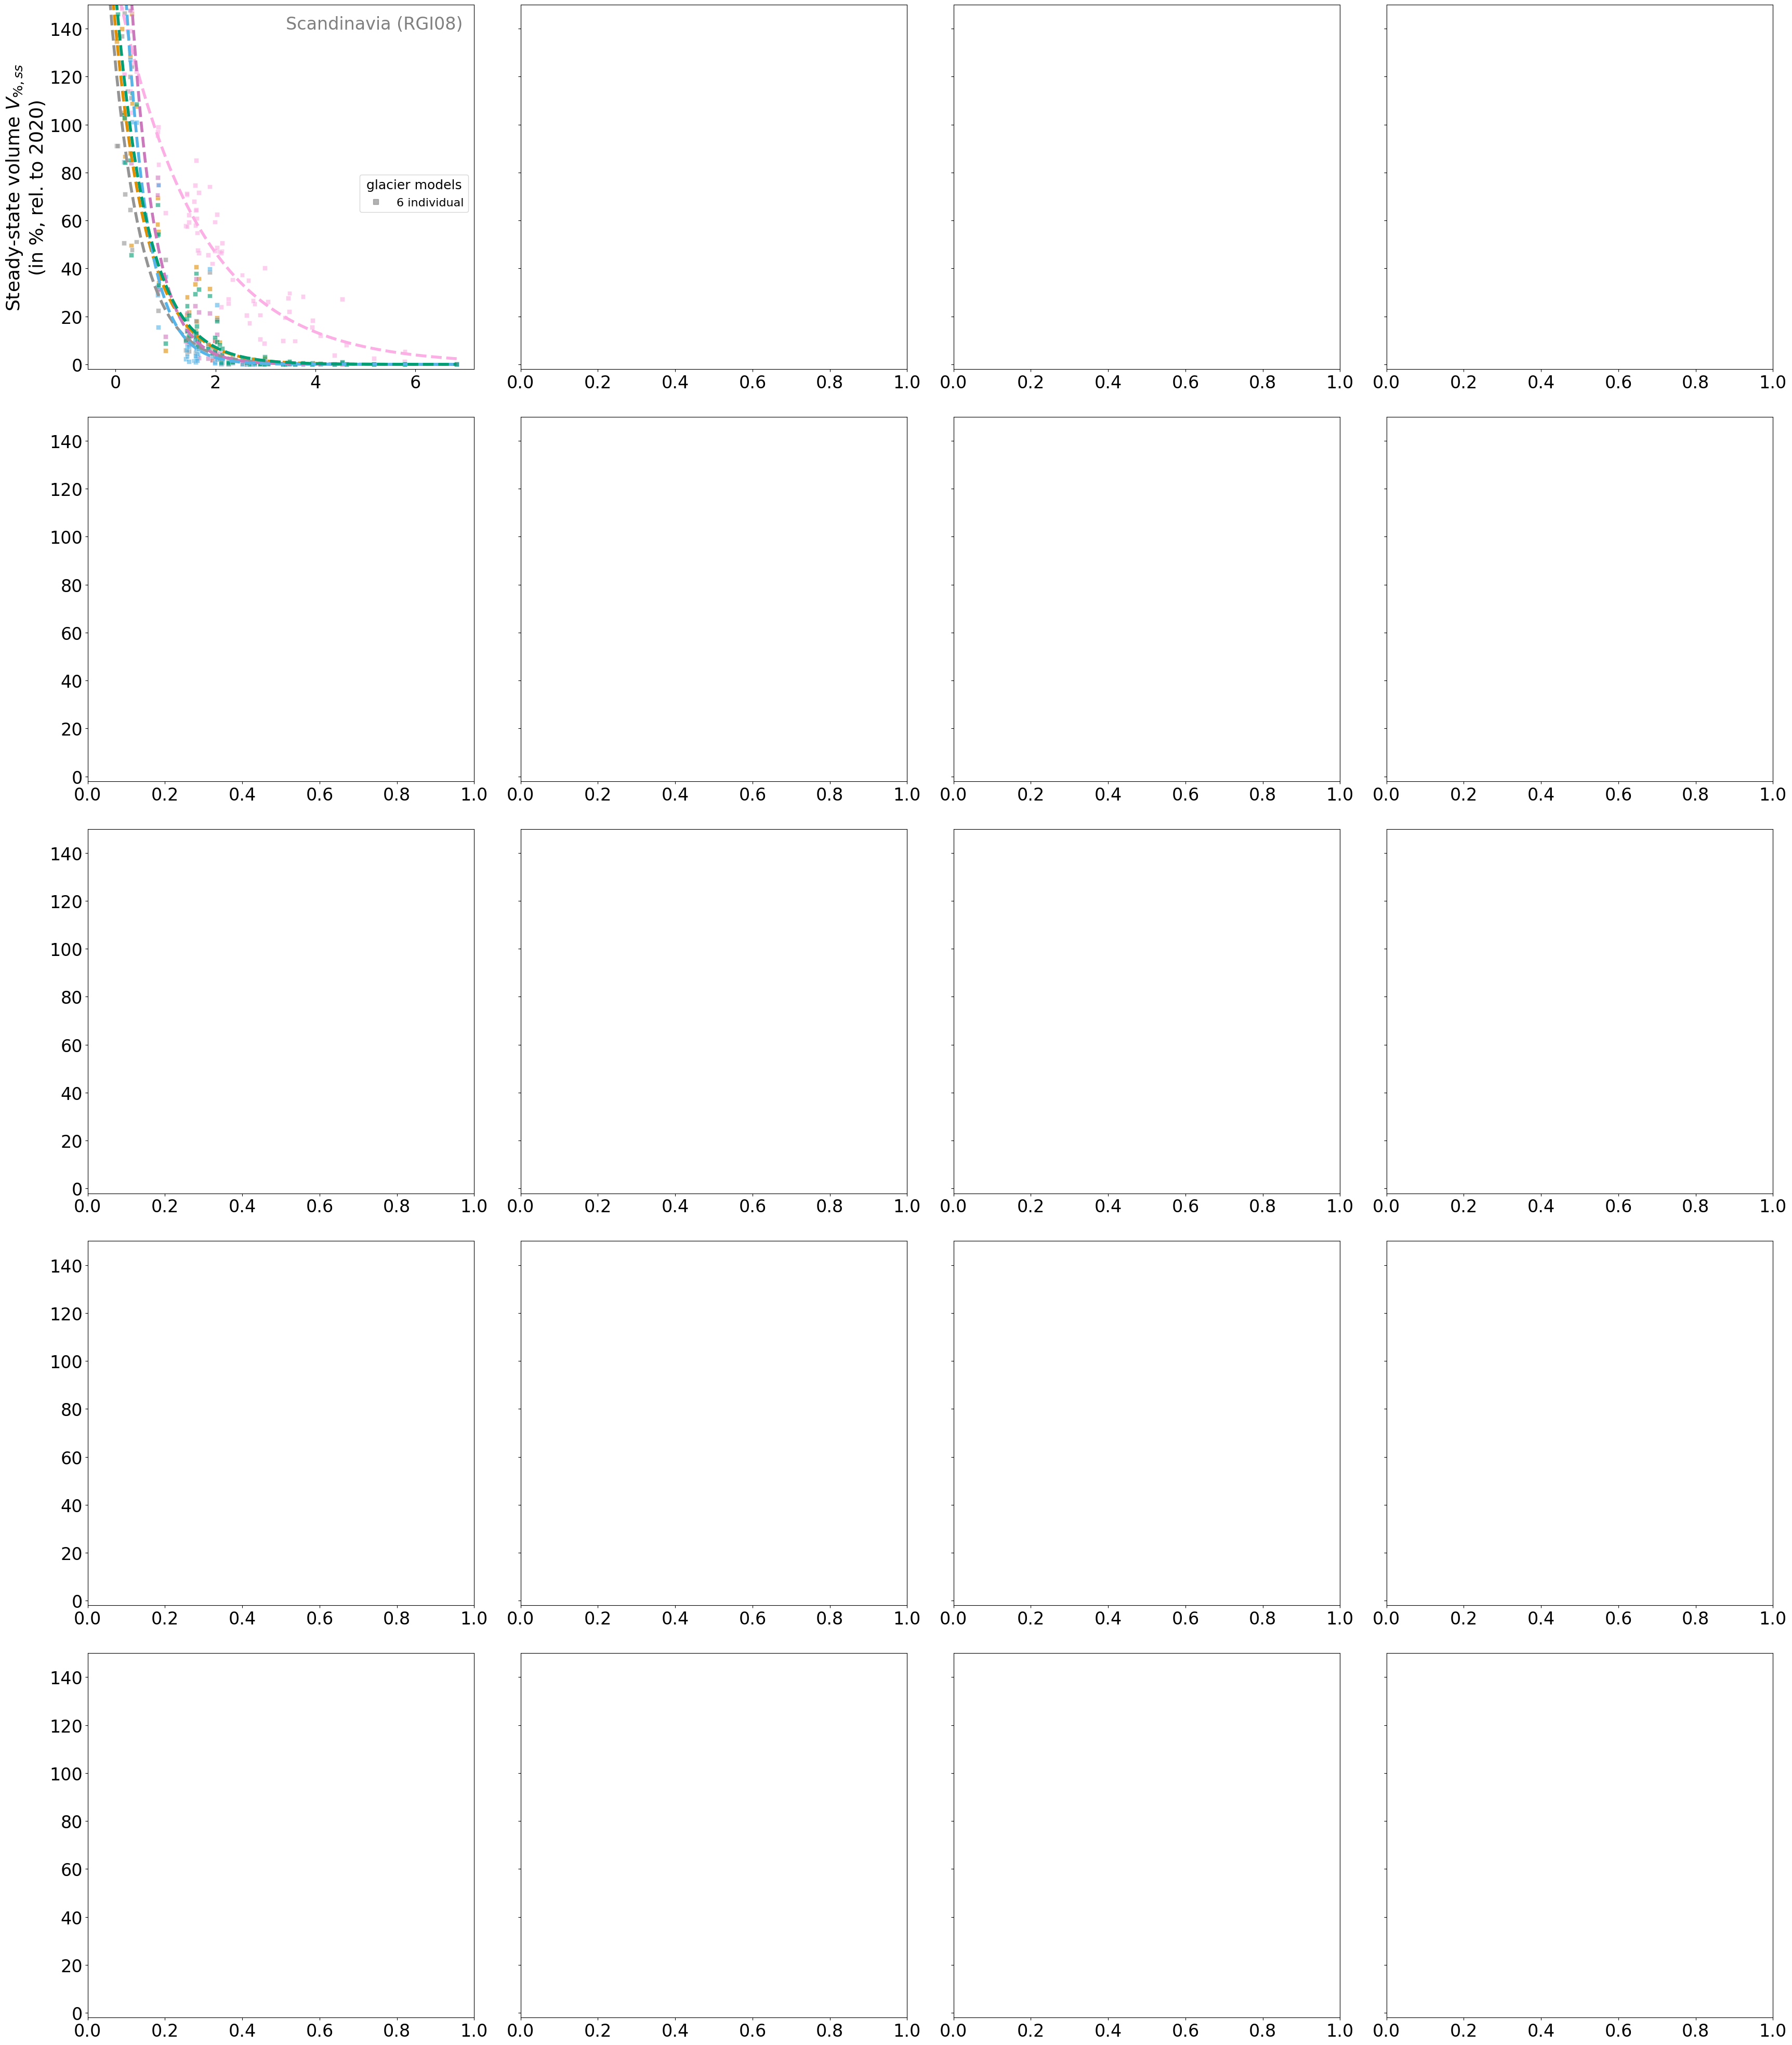

In [274]:
fit_to_per_glacier_models = True

show_median = False

fit_to_median=False # False

# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Jun29' #'apr04' (has OGGM runaway effect of glaciers inside)
fill_option = 'repeat_last_100yrs' #'repeat_last_20yrs'
add_lowess=True
#avg_over = '100yr'
temp_ch = '' #'regional_glacier'
shift_years = True
temp_above_0_8_sel = False


sim_years = [5000] #,50,100,300,500] #100, 300, 500, 

qs = [0.5] #[0.05,0.25,0.5,0.75,0.95]

N = 30#50 #200#50 #500 #100 #100 #100 #100#100
it = 1 #2#2

rgi_regs_global = ['All','01', '02', '03', '04', '05', '06', '07',
                   '08', '09', '10', '11', '12', '13', '14', '15',
                   '16', '17', '18', '19']
if test:
    rgi_regs_global = ['08'] #, '16']
write_exp_text = True


import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from moepy import lowess, eda

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
f_path_data ='/home/users/lschuster/GlacierMIP3/'

f_path ='/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/'
f_path_f = '/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/figures/'
try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_isimip3b.csv', index_col = 0)

from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
glac_models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

dict_model_col ={}
for h, p in zip(hue_order, pal_models):
    dict_model_col[h] = p

# test without Zeokllari and OGGM-VAS
sel = False
if sel:
    glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16'] #, 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
else:    
    ds_reg_models = ds_reg_models.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])


ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)

def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    #print(_p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc'))
    _p = _p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc')
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__

pd_rgi_stats_w_hugonnet = pd.read_csv(f'{f_path}rgi_vs_2020_volume_hugonnet_estimates.csv', index_col = [0])

ds_reg_yr_shift= xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc')
ds_reg_yr_shift_vol = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3
ds_reg_yr_shift_vol_med = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3.median(dim='model_author')

show_color_models = True
plt.rc('font', size=24)  


# option A: choose 20-year period before and do the average!
import numpy as np
from scipy.optimize import curve_fit

#sim_year = 5000
# Define the exponential decay function, want to ensure that it -> zero if temperature is large!!!


#rgi_regs_global = ['03']# 
current_deltaT = 1.2

if shift_years:
    p_shift = '_shift_years_rel_2020'
else:
    p_shift = ''


    
for temp_above_0_8 in [temp_above_0_8_sel]: #,False]: True

    for version in ['simple']:
        jj=0
        if version == 'simple':
            def exponential_decay(x, a, b):
                # avoind overflow -> does not work ... 
                exp_values = -b * x
                #exp_values = np.clip(exp_values, -709, 709)  # Clip values to avoid overflow
                return a * np.exp(exp_values) #+ c * np.exp(-d * x**2)#**c 
            param_bounds = ([0, 0], [1000, 5])
            pd_exp_decay_fits_simple = pd.DataFrame(index=np.arange(0,20*9,1),
                                                    columns=['rgi_reg','year',
                                                             'a_simple', 'b_simple', 'model_author'])

        else:
            def exponential_decay(x, a, b,c,d):
                exp_values_b = -b * x
                #exp_values_b = np.clip(exp_values_b, -709, 709)  # Clip values to avoid overflow

                exp_values_d = -d * x**2
                #exp_values_d = np.clip(exp_values_d, -709, 709)  # Clip values to avoid overflow
                return a * np.exp(exp_values_b) + c * np.exp(exp_values_d)#**c 
            param_bounds = ([0, 0,0,0], [1000, 5,1000, 5])
            pd_exp_decay_fits_adv = pd.DataFrame(index=np.arange(0,20*9,1),
                                                 columns=['rgi_reg','year',
                                                          'a_comp', 'b_comp',
                                                          'c_comp', 'd_comp', 'model_author'])

        for sim_year in sim_years: # 
            if sim_year <5000:
                avg_over = '20yr'
            else:
                avg_over = '100yr'
            if temp_above_0_8:
                add= '_temp_above_0_8'
            else:
                add = ''
    
            if sim_year==5000:
                v_n = r'$V_{\%,ss}$'
                state = 'Steady-state volume'
            elif sim_year == 50:
                v_n = r'$V_{\%,50yr}$'
                state = 'Volume after 50 years'
            elif sim_year == 100:
                v_n = r'$V_{\%,100yr}$'
                state = 'Volume after 100 years'
            elif sim_year == 300:
                v_n = r'$V_{\%,300yr}$'
                state = 'Volume after 300 years'
            elif sim_year ==500:
                v_n = r'$V_{\%,500yr}$'
                state = 'Volume after 500 years'
            if avg_over=='100yr':
                sim_year_avg = 100
            elif avg_over=='60yr':
                sim_year_avg = 60
            else:
                sim_year_avg = 20
            fig, axs = plt.subplots(5,4,figsize=(35,40), sharey=True) #, sharey='row') #, sharex=True)
            if shift_years:
                ds_reg_models_med_vol_roll = ds_reg_yr_shift_vol_med.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
                ds_reg_models_vol_roll = ds_reg_yr_shift_vol.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
            else:
                ds_reg_models_med_vol_roll = ds_reg_models_med_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
                ds_reg_models_vol_roll = ds_reg_models_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
            
            df_quantiles_l = []
            sel_l = []
            for j, rgi_reg in enumerate(rgi_regs_global):
                if rgi_reg == 'All':
                    _rgi_reg = 'Globally'
                else:
                    _rgi_reg = rgi_reg
                vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[_rgi_reg]['regional_volume_m3_2020']

                if j<4:
                    ax = axs[0][j]
                elif j <8:
                    ax = axs[1][j-4]
                elif j <12:
                    ax = axs[2][j-8]
                elif j <16:
                    ax = axs[3][j-12]
                elif j <20:
                    ax = axs[4][j-16]
                    
                region = f'RGI{rgi_reg}_glacier'

                if rgi_reg == 'All':
                    # get the temp.
                    if temp_ch != 'regional_glacier':
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global')
                    else:
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global_glacier')
                    if shift_years:
                        # we have done the dropping of everything after 4950, so the last year should be fine 
                        ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')
                        # make sure that we only take here global models ... 
                        ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(year_after_2020=-1).dropna(dim='model_author')
                        ds_t2 = 100*ds_t2/vol_2020_reg
                        ds_t = 100*ds_reg_models_med_vol_sel/vol_2020_reg # TODO checkt that this is the sum ... 
                    
                    else:
                        ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(simulation_year=-1).sum(dim='rgi_reg')
                        # make sure that we only take here global models ... 
                        ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(simulation_year=-1).dropna(dim='model_author')
                        ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sum(dim='rgi_reg', min_count=19)

                        ds_t = 100*ds_reg_models_med_vol_sel/ds_reg_models_med_vol.isel(simulation_year=0).sum(dim='rgi_reg')
                    
                    pd_tt2 = ds_t2.to_dataframe()
                    try:
                        pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
                    except:
                        pass
                    pd_tt2 = pd_tt2.reset_index()
                else:
                    # get the temp. 
                    if temp_ch != 'regional_glacier':
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global')
                    else:
                        pd_global_temp_exp_m = get_glob_temp_exp(region=region)

                    if fit_to_median:
                        if shift_years:
                            # TODO
                            ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/vol_2020_reg
                        else:
                            ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
                        ds_t = ds_t2.median(dim='model_author') 

                        pd_tt2 = ds_t2.to_dataframe()
                        try:
                            pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
                        except:
                            pass
                        pd_tt2 = pd_tt2.reset_index()
                    else:
                        if shift_years:
                            # TODO
                            ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t = 100*ds_t/vol_2020_reg
                        else:
                            ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t = 100*ds_t/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
                        ds_t2= ds_t
                pd_tt = ds_t2.to_dataframe()
                try:
                    pd_tt = pd_tt.drop(columns=['gcm','period_scenario'])
                except:
                    pass
                pd_tt = pd_tt.reset_index()
                # much better if we create a gcm_period_scenario column to later assign the correct temp. series ... 
                pd_global_temp_exp_m_r = pd_global_temp_exp_m.reset_index()
                pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario'] = pd_global_temp_exp_m_r['gcm'] +'_'+pd_global_temp_exp_m_r['period_scenario']
                pd_global_temp_exp_m_r.index = pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario']
                pd_tt2['gcm'+'_'+'period_scenario'] = pd_tt2['gcm'] +'_'+pd_tt2['period_scenario']
                pd_tt2.index = pd_tt2['gcm'+'_'+'period_scenario']
                pd_tt2.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                pd_tt2 = pd_tt2.reset_index(drop=True)

                pd_tt['gcm'+'_'+'period_scenario'] = pd_tt['gcm'] +'_'+pd_tt['period_scenario']
                pd_tt.index = pd_tt['gcm'+'_'+'period_scenario']
                pd_tt.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                pd_tt = pd_tt.reset_index(drop=True)


                pd_tt_above0 = pd_tt #.loc[pd_tt.volume_m3>0]  ## probably it is ok to also fit the zero volume estimates 
                # if I want to remove the very uncertain experiments,
                # I still want to keep those that are near to 
                # 1.2°C. However, there are no experiments directly at 1.2°C
                # and only one at +1, so, we should rather do the fit with >= +0.8°C
                if temp_above_0_8:
                    pd_tt_above0 = pd_tt_above0.loc[pd_tt_above0['temp_ch_ipcc']>=0.8]
                temp = pd_tt_above0['temp_ch_ipcc'].values

                q = 'volume_m3' # this is actually the 'relative volume change (in %)'
                rel_vol = pd_tt_above0[q].values

                if rgi_reg == 'All':
                    ax.text(0.97, 0.97, 'Globally', color='grey',transform=ax.transAxes, fontsize=24, va='top', ha='right')
                else:
                    nam = d_reg_num_name[rgi_reg]
                    ax.text(0.97, 0.97, f'{nam} (RGI{rgi_reg})', color='grey',transform=ax.transAxes, fontsize=24, va='top', ha='right')

                ax.set_ylabel(f'{state} '+f'{v_n}'+'\n(in %, rel. to 2020)', fontsize=26)

                if show_color_models:                    
                    if rgi_reg=='All' and show_median:
                        pd_ttx = pd_tt2
                        pd_ttxx = pd_tt
                        # add legend...
                        n_models = len(pd_ttx.model_author.unique())

                        line2 = Line2D([0], [0], label=f'{n_models} individual global models', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)
                        #add handles
                        if show_median:
                            line1 = Line2D([0], [0],
                                           label='global model median:\n'+r'$\sum_{rgi=1}^{19} V_{median,rgi}$',
                                           color='black', ms=10, marker='o', lw=0,alpha = 0.8)
                            handles= [line1, line2]
                        else:
                            handles = [line2]
                        #add legend
                        leg2=ax.legend(handles=handles, loc = 'upper right', fontsize=16, bbox_to_anchor=(1,0.55))
                    else:
                        if fit_to_median:
                            pd_ttx = pd_tt2
                            pd_ttxx = pd_tt
                        else:
                            pd_ttx = pd_tt
                            pd_ttxx = pd_tt[['temp_ch_ipcc', 'volume_m3']].groupby(['temp_ch_ipcc']).median().reset_index()
                        n_models = len(pd_ttx.model_author.unique())
                        line2 = Line2D([0], [0], label=f'{n_models} individual', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)

                        if show_median:
                            line1 = Line2D([0], [0], label='median', color='black', ms=10, marker='o', lw=0,alpha = 0.8)
                            #add handles
                            handles= [line1, line2]
                        else:
                            handles = [line2]
                        #add legend
                        leg2=ax.legend(handles=handles, title='glacier models',
                                      loc = 'upper right', fontsize=16, title_fontsize=18, bbox_to_anchor=(1,0.55))
                    sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                                    y='volume_m3', #'volume (km3)',
                                    data = pd_ttx,
                                    hue_order=hue_order,
                                    hue='model_author',
                                    palette=pal_models,
                                    legend=False, s=40, alpha = 0.6, marker='s')
                    # if globally, the median comes from all estimates (also from those models that are only available for some RGI regions ...)
                    if show_median:
                        sns.scatterplot(ax=ax,
                                    x='temp_ch_ipcc',
                                    y='volume_m3', #'volume (km3)',
                                    data = pd_ttxx,
                                    color='black',
                                    #hue='temp_ch_ipcc',
                                    #palette='flare',
                                    legend=False, s=80, alpha = 0.8)
                        
                else:
                    sns.scatterplot(ax=ax,
                                x='temp_ch_ipcc',
                                y='volume_m3', #'volume (km3)',
                                data = pd_tt,
                                color='black',
                                #hue='temp_ch_ipcc',
                                #palette='flare',
                                legend=False, s=80, alpha = 0.3)
                if temp_ch == 'regional_glacier':
                    ax.set_xlabel(r'$\Delta$T$_{reg,glacier-area}$ (°C, compared to pre-industrial)')
                else:
                    ax.set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial)')
                    
                
                for m in pd_tt_above0.model_author.unique():

                    rel_vol_m = pd_tt_above0.loc[pd_tt_above0.model_author==m].volume_m3.values #[q]
                    temp_m = pd_tt_above0.loc[pd_tt_above0.model_author==m].temp_ch_ipcc.values
                    x,y = temp_m, rel_vol_m

                    # Perform the curve fitting
                    popt, pcov = curve_fit(exponential_decay, x-current_deltaT, y,loss='soft_l1', f_scale=0.1, bounds = param_bounds)  # Lower and upper bounds for a and b)
                    # Generate a higher density x range for plotting the fitted curve
                    x_dense = np.linspace(x.min(), x.max(), 100)
                    fit_vars = popt #c_opt

                    # Extract the optimized parameters
                    if version == 'simple':
                        a_opt, b_opt = popt #c_opt
                        # Compute the fitted y values
                        y_fitted = exponential_decay(x_dense-current_deltaT, a_opt, b_opt)

                        func_vars= f'{v_n}'+r'(ΔT)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$ΔT))' #\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                        #r'V$_{ss,rel}$(ΔT)=a$\cdot$e'+r'$^{-b\cdot(ΔT-1.2)}$'
                        if current_deltaT !=0:
                            if temp_ch == 'regional_glacier':
                                #func_vars= r'$V_{\%}$(ΔT$_{reg}$)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*('+r'ΔT$_{reg}$'+f'-{current_deltaT}°C))' 
                                func_vars= f'{v_n}'+r'(ΔT$_{reg}$)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT$_{reg}$-'+f'{current_deltaT}°C))'

                                fs_label = 14
                            else:
                                #func_vars= r'$V_{\%}$(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*(ΔT-{current_deltaT}°C))' 
                                func_vars= f'{v_n}'+r'(ΔT)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT-'+f'{current_deltaT}°C))'
                                fs_label = 18
                            #\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                    else:
                        a_opt, b_opt, c_opt, d_opt = popt
                        # Compute the fitted y values
                        y_fitted = exponential_decay(x_dense, a_opt, b_opt, c_opt, d_opt)
                        func_vars= 'V%(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*ΔT)\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                    ax.plot(x_dense, y_fitted, '--', label=func_vars,
                            color=dict_model_col[m], lw=4)
                    
                    
                    
                    if version == 'simple':
                        pd_exp_decay_fits_simple.iloc[jj] = (rgi_reg,sim_year, a_opt, b_opt, m)
                    else:
                        pd_exp_decay_fits_adv.iloc[jj] = (rgi_reg,sim_year, a_opt, b_opt, c_opt, d_opt,m)
                    jj+=1

                    ax.set_ylim([-2,150])
                    if temp_ch == 'regional_glacier':
                        ax.set_xlim([pd_global_temp_exp_glac['temp_ch_ipcc'].min()*1.001, pd_global_temp_exp_glac['temp_ch_ipcc'].max()*1.001])
                        ax.set_ylim([-2,400])
                    else:
                        ax.set_ylim([-2,150])

                    if j<16:
                        ax.set_xlabel('')
                    if j not in [0,4,8,12,16,20]:
                        ax.set_ylabel('')
                        
                    
                    if add_lowess:
                        eval_x =np.arange(x.min().round(1), x.max()*1.001, 0.05)
                        df_quantiles_ll = []
                        for frac in np.arange(0.3,1,0.02):
                            df_quantiles = lowess.quantile_model(x, y, x_pred=np.concatenate([eval_x,x]),
                                                                 frac=frac, num_fits=N, robust_iters=it,
                                                             qs=qs)
                            q = 0.5 # selection criteria are still done via the median at the moment ... 
                            lowi = df_quantiles[q].copy()
                            lowi[lowi<0] = 0
                            # we just only allow for monotonically decreasing functions ... 
                            df_quantiles[q] = np.concatenate([np.minimum.accumulate(df_quantiles.iloc[:len(eval_x)][q].values), )
                            #np.concatenate(np.minimum.accumulate(df_quantiles.iloc[:len(eval_x)][q].values), np.repeat(np.NaN, len(x)))

                            #ax.plot(df_quantiles.iloc[:len(eval_x)].index, lowi.iloc[:len(eval_x)], #label=f'lowess, frac= {frac}',
                            #        alpha = 0.8, lw=1, color='grey', zorder=-1)
                            df_quantiles['model_author'] = m
                            df_quantiles['frac'] = frac
                            df_quantiles['region'] = rgi_reg
                            df_quantiles['year'] = sim_year
                            df_quantiles['fit_to_median'] = fit_to_median
                            df_quantiles['temp_ch'] = temp_ch
                            df_quantiles['avg_over'] = avg_over
                            df_quantiles['it'] = it
                            df_quantiles['N'] = N
                            df_quantiles['fit_opt'] = 'lowess_fit'
                            df_quantiles['shift_years_2020'] = shift_years
                            #df_quantiles['version'] = version
                            #df_quantiles['y'] = np.NaN
                            df_quantiles['y'] = np.concatenate([np.repeat(np.NaN, len(eval_x)), y])
                            #df_quantiles.iloc[len(eval_x):,'y'] = y
                            #df_quantiles.loc[df_quantiles.iloc[len(eval_x):].index,'y'] = y
                            df_quantiles['add'] = add
                            df_quantiles[f'min_{q}_diff'] = (df_quantiles[q].iloc[:len(eval_x)-1].values - df_quantiles[q].iloc[1:len(eval_x)].values).min()
                            df_quantiles[f'min_{q}'] = df_quantiles[q].min()
                            df_quantiles[f'min_{q}_diff_above_zero'] = (lowi.iloc[:len(eval_x)-1].values - lowi.iloc[1:len(eval_x)].values).min()
                            df_quantiles['median_absolute_deviation'] =  np.abs(df_quantiles.iloc[len(eval_x):]['y'] - df_quantiles.iloc[len(eval_x):][0.5]).median()
                            df_quantiles['rmse'] =  np.sqrt(np.mean((df_quantiles.iloc[len(eval_x):]['y']-df_quantiles.iloc[len(eval_x):][0.5])**2))
                            #np.abs(df_quantiles.iloc[len(eval_x):]['y'] - df_quantiles.iloc[len(eval_x):][0.5]).median()

                            if np.all(df_quantiles[f'min_{q}_diff_above_zero']>=0):
                                df_quantiles['algorithm_sel'] = 'only_decreasing'
                                if df_quantiles[q].min()>=0:
                                    #ax.plot(df_quantiles.iloc[:len(eval_x)].index, lowi.iloc[:len(eval_x)], #label=f'lowess, frac= {frac}',
                                    #    alpha = 0.8, lw=1, color='red', zorder=-1)
                                    df_quantiles['algorithm_sel'] = 'non_negative_and_decreasing'
                            else:
                                df_quantiles['algorithm_sel'] = 'not_selected'
                            df_quantiles_l.append(df_quantiles)
                            df_quantiles_ll.append(df_quantiles)
                        df_quantiles_ll_concat = pd.concat(df_quantiles_ll)
                        #sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac == df_quantiles_ll_concat[f'min_{q}_diff_above_zero'].min().frac]
                        old = False
                        if old: 
                            if (df_quantiles_ll_concat['min_0.5'].max()>=0) and len(df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing'])>=1:
                                _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing']
                                min_mad = _sel['median_absolute_deviation'].min()

                                max_diff_above_zero = _sel[f'min_{q}_diff_above_zero'].max()

                                #sel = _sel.loc[_sel.median_absolute_deviation == min_mad]
                                min_rmse = _sel['rmse'].min()
                                sel = _sel.loc[_sel.rmse == min_rmse]
                                sel = sel.sort_values('x')
                                #ax.plot(sel.index, sel[0.5], color='darkgreen', lw=3)

                                #sel2 = _sel.loc[_sel[f'min_{q}_diff_above_zero'] == max_diff_above_zero]
                                #sel2 = sel2.sort_values('x')
                                #ax.plot(sel2.index, sel2[0.5], color='blue', lw=3)

                            elif len(df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='only_decreasing'])>=1:
                                _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='only_decreasing']
                                max_min = _sel['min_0.5'].max()
                                sel = _sel.loc[_sel['min_0.5'] == max_min]
                                sel = sel.sort_values('x')

                                min_rmse = _sel['rmse'].min()
                                sel = _sel.loc[_sel.rmse == min_rmse]
                                sel = sel.sort_values('x')
                                # set values below zero to zero 
                                assert len(sel)>0
                                #ax.plot(sel.index, sel[0.5], color='orange', lw=3)
                            else:
                                # if nothing else work, just use the fit that is the most
                                # "monotonically" decreasing ... 
                                _max_min_diff =df_quantiles_ll_concat.groupby('frac')[f'min_{q}_diff_above_zero'].min()
                                frac = _max_min_diff.idxmax().round(3)
                                _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac.round(3) == frac]
                                #_sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat[f'min_{q}_diff_above_zero']]
                                sel = _sel.sort_values('x')
                                # set values below zero to zero 
                                assert len(sel)>0
                                #ax.plot(sel.index, sel[0.5], color='yellow', lw=3)
                        else:
                            _sel = df_quantiles_ll_concat #.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing']
                            min_rmse = _sel['rmse'].min()
                            sel = _sel.loc[_sel.rmse == min_rmse]
                            sel = sel.sort_values('x')

                        # text = ''
                        #for temp in [1.2,1.5,2.0,2.7, 4.0]:
                        #    num_y=0.5
                        #    Ttemp_vol = int(sel.loc[np.round(sel.index,2)==temp, 0.5].round(0)) #c_opt
                        #    if Ttemp_vol < 10:
                        #        Ttemp_vol = f'  {Ttemp_vol}'
                        #    text = text + f'{Ttemp_vol}%\n'
                        #ax.text(0.995, num_y, text, color='red',transform=ax.transAxes, fontsize=22, va='bottom', ha='right')
                        #print(rgi_reg, sel.frac.unique())
                        for qq in qs:
                            sel.loc[sel[qq]<0, qq] = 0
                        ax.plot(sel.index, sel[0.5], color=dict_model_col[m], lw=4)
                        if len(qs)>1:
                            #ax.fill_between(sel.index, sel[0.25], sel[0.75], color='red', alpha = 0.2)
                            ax.fill_between(sel.index, sel[0.25], sel[0.75], color='red', alpha = 0.25)
                            ax.fill_between(sel.index, sel[0.05], sel[0.95], color='red', alpha = 0.15)

                        sel_l.append(sel)
                        
            plt.tight_layout()
            if fit_to_median:
                add = add + '_fit_to_median'
            if add_lowess:
                add = add + '_lowess_added'
            if len(qs)>1:
                add = add + '_quantiles_added'
                
            if not test: 

                if temp_ch != 'regional_glacier':
                    plt.savefig(f'{f_path_f}2_per_model_glacier_volume_yr{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{version}{add}_current12deg.png')
                else:
                    plt.savefig(f'{f_path_f}2_per_model_glacier_volume_yr{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{version}{add}_current12deg_reg_glacier_temp_ch.png')
                #if not test: 
                #    plt.close()

                pd_quantiles_concat = pd.concat(df_quantiles_l)
                pd_sel = pd.concat(sel_l)
                if temp_ch != 'regional_glacier':
                    pd_exp_decay_fits_simple.to_csv(f'{f_path}per_glacier_lowess_calib/fitted_per_model_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}.csv')
                    pd_quantiles_concat.to_csv(f'{f_path}per_glacier_lowess_calib/fitted_per_model_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}.csv')
                    pd_sel.to_csv(f'{f_path}per_glacier_lowess_calib/fitted_per_model_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}.csv')
                else:
                    pd_exp_decay_fits_simple.to_csv(f'{f_path}per_glacier_lowess_calib/fitted_per_model_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}.csv')
                    pd_quantiles_concat.to_csv(f'{f_path}per_glacier_lowess_calib/fitted_per_model_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}.csv')
                    pd_sel.to_csv(f'{f_path}per_glacier_lowess_calib/fitted_per_model_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}.csv')

                #pd_exp_decay_fits_adv.to_csv(f'fitted_glacier_response_to_global_temp_ch_complex_20yr_avg_period{add}.csv')

In [278]:
_sel.rmse.dropna()

Series([], Name: rmse, dtype: float64)

array([ 1.70750620e+02,  1.64623220e+02,  1.58583585e+02,  1.52635713e+02,
        1.46804935e+02,  1.41089470e+02,  1.35465510e+02,  1.29901439e+02,
        1.24355862e+02,  1.18716876e+02,  1.12945967e+02,  1.07093261e+02,
        1.01231790e+02,  9.53733071e+01,  8.94821540e+01,  8.36079221e+01,
        7.78274089e+01,  7.22037221e+01,  6.67746815e+01,  6.15491827e+01,
        5.64505564e+01,  5.14378107e+01,  4.65563144e+01,  4.18730671e+01,
        3.74243774e+01,  3.32675060e+01,  2.94772939e+01,  2.61169472e+01,
        2.32326994e+01,  2.08566554e+01,  1.90161760e+01,  1.76973210e+01,
        1.68105856e+01,  1.61820215e+01,  1.55745573e+01,  1.47516822e+01,
        1.36257234e+01,  1.23939793e+01,  1.12169007e+01,  1.00686045e+01,
        8.92912583e+00,  7.80474810e+00,  6.72406351e+00,  5.69421428e+00,
        4.71579745e+00,  3.78272985e+00,  2.89260990e+00,  2.07902356e+00,
        1.36352137e+00,  7.49059024e-01,  2.42314872e-01, -1.51728008e-01,
       -4.35925214e-01, -

In [251]:
                pd_quantiles_concat = pd.concat(df_quantiles_l)


In [262]:
_s.loc[_s.rmse.argmin()]

quantiles
x                                    -0.2
0.5                            426.101539
model_author                     OGGM_v16
frac                                  0.3
region                                 16
year                                 5000
fit_to_median                       False
temp_ch                                  
avg_over                            100yr
it                                      1
N                                      30
fit_opt                        lowess_fit
shift_years_2020                     True
y                                     NaN
add                                      
min_0.5_diff                    -3.340177
min_0.5                          0.055276
min_0.5_diff_above_zero         -3.340177
median_absolute_deviation        2.155947
rmse                             19.25919
algorithm_sel                not_selected
Name: 0, dtype: object

In [316]:
_s = pd_quantiles_concat.loc[pd_quantiles_concat.region == '08']

In [317]:

#_s = _s.loc[_s.algorithm_sel == 'only_decreasing']
_s = _s.loc[_s.model_author=='OGGM_v16']


In [318]:
_s = _s.reset_index()

In [319]:
_s.temp_ch.values

array(['', '', '', ..., '', '', ''], dtype=object)

In [320]:
x = _s.dropna().loc[_s.frac==0.30,'x'].values
y = _s.dropna().loc[_s.frac==0.30,'y'].values


In [321]:
x_data, y_data = x, y
# Assuming x_data and y_data are your input data
# Ensure x_data is sorted as isotonic regression requires it
x_sorted = sorted(x_data)
y_sorted = [y for _, y in sorted(zip(x_data, y_data))]

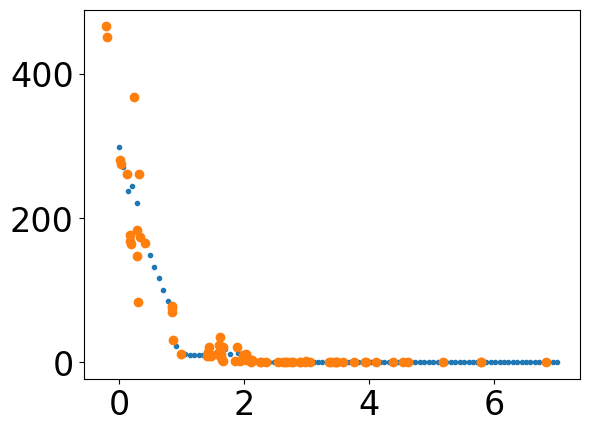

In [322]:
#title_suffix = 'smooth data (assumed ground truth)'
#graph(in_array, curve, title_suffix , scatter=True, solid_line=False)

title_suffix = '  –  sparse data' +   ' - with B-Spline'
import scipy

x_interp = np.linspace(0, 7, 100)
BSpline = scipy.interpolate.make_interp_spline(x_sorted, y_sorted, 1)
y_BSpline = BSpline(x_interp)

spline_duple = [(x_interp, y_BSpline)  ]
plt.plot(x_interp, 
         y_BSpline, '.')
plt.plot(x_sorted, y_sorted, 'o')

In [314]:
x

array([], dtype=float64)

In [279]:
scipy.stats.spline?

Object `scipy.stats.spline` not found.


In [153]:
N=100

100%|████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


<AxesSubplot:xlabel='x', ylabel='y'>

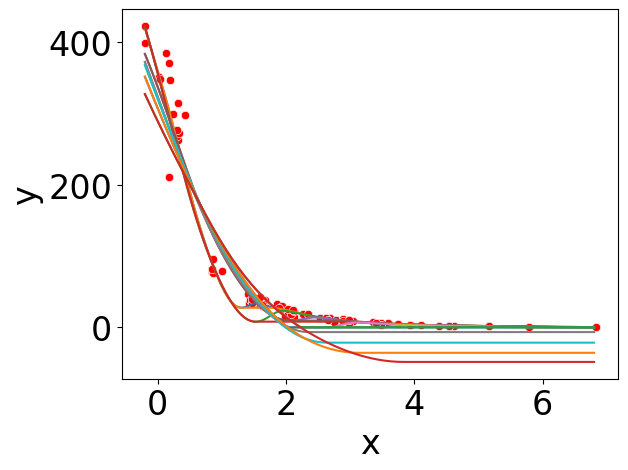

In [240]:
from moepy import lowess, eda

for frac in np.arange(0.3,0.9,0.1):

    df_quantiles = lowess.quantile_model(x, y, x_pred=np.concatenate([eval_x,x]),
                                         frac=frac, num_fits=N, robust_iters=it,
                                     qs=qs)
    q = 0.5 # selection criteria are still done via the median at the moment ... 

    y_lowess_monotonic = np.minimum.accumulate(df_quantiles.iloc[:len(eval_x)][q])

    lowi = df_quantiles[q].copy()
    lowi[lowi<0] = 0
    
    plt.plot(eval_x, lowi.values[:len(eval_x)])
    plt.plot(eval_x, y_lowess_monotonic, )

sns.scatterplot(data=_s,  x='x', y='y', color='red') 


<AxesSubplot:xlabel='x', ylabel='y'>

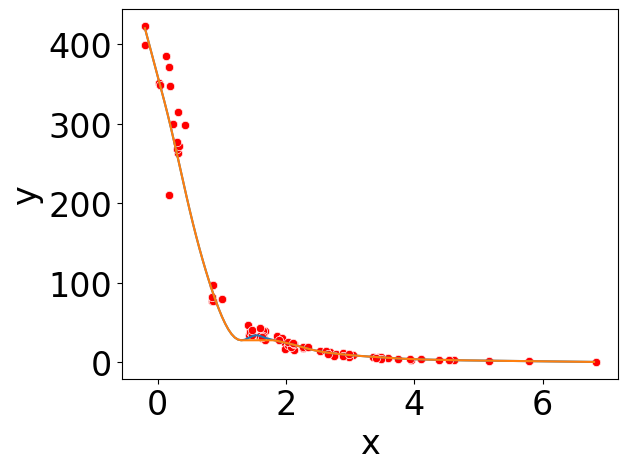

In [195]:
np.array(y_sorted)

array([3.99046516e+02, 4.22908125e+02, 3.50916607e+02, 3.48272155e+02,
       3.85081209e+02, 3.70909852e+02, 2.10606083e+02, 3.46851928e+02,
       2.99372467e+02, 2.76378556e+02, 2.68696038e+02, 2.62461545e+02,
       3.14635571e+02, 2.72443455e+02, 2.98622596e+02, 7.73968835e+01,
       8.14371022e+01, 7.66833350e+01, 9.65112481e+01, 7.94712373e+01,
       4.63881797e+01, 3.44738427e+01, 3.81903941e+01, 4.04835101e+01,
       4.03038407e+01, 3.47215117e+01, 3.33315932e+01, 3.34034981e+01,
       4.30008356e+01, 3.21410058e+01, 3.07727168e+01, 3.03350362e+01,
       3.19327347e+01, 3.25757844e+01, 3.87248364e+01, 3.89532717e+01,
       2.80922939e+01, 3.29609028e+01, 2.74586927e+01, 3.06431415e+01,
       2.45593435e+01, 1.59877496e+01, 2.55453518e+01, 2.12394300e+01,
       1.87997296e+01, 2.39375131e+01, 2.26553930e+01, 1.48969983e+01,
       2.24889641e+01, 1.88492688e+01, 1.80647597e+01, 1.84708652e+01,
       1.34766363e+01, 1.33815198e+01, 9.88905397e+00, 1.28846924e+01,
      

In [222]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from statsmodels.nonparametric.smoothers_lowess import lowess

# Assuming x_data and y_data are your input data
lowess_fit = lowess(y_data, x_data, frac=0.3)  # Adjust frac as needed
x_lowess, y_lowess = lowess_fit.T

# Ensure the LOWESS curve is monotonically decreasing
y_lowess_monotonic = np.minimum.accumulate(y_lowess)

# Fit a monotonic spline to the smoothed data
spline = UnivariateSpline(x_lowess, y_lowess_monotonic, k=3)  # Adjust the spline degree as needed

# Generate the fitted curve using the spline
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = spline(x_fit)

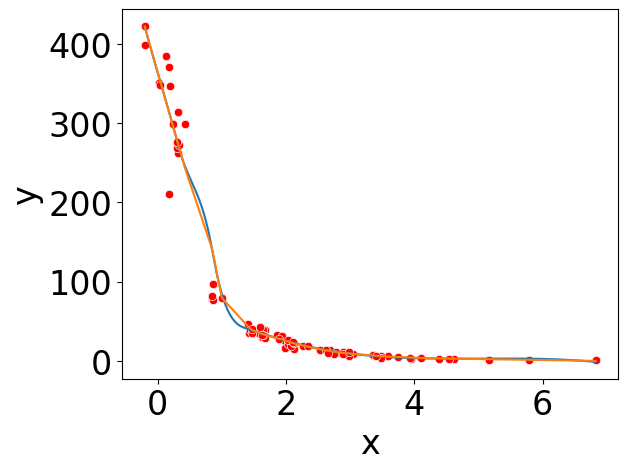

In [247]:
plt.plot(x_fit, y_fit)
sns.scatterplot(data=_s,  x='x', y='y', color='red') 
plt.plot(x_lowess,y_lowess)

In [198]:
import numpy as np
from scipy.optimize import minimize

x_data, y_data = x, y
# Assuming x_data and y_data are your input data
# Ensure x_data is sorted as isotonic regression requires it
x_sorted = sorted(x_data)
y_sorted = [y for _, y in sorted(zip(x_data, y_data))]

# Define the function to minimize (e.g., MSE) subject to a monotonicity constraint
def objective_function(params, x, y):
    predicted = params[0] * x + params[1]  # Define your function here
    mse = np.mean((predicted - y) ** 2)  # Minimize mean squared error
    # Implement monotonicity constraint
    penalty = np.sum(np.diff(predicted) > 0)  # Penalize non-decreasing sequences
    return mse + penalty  # Combine MSE and penalty

# Initial guess for parameters (slope and intercept)
initial_guess = [1, -1.0]  # Change according to your function

# Minimize the objective function with the monotonicity constraint
result = minimize(
    objective_function,
    initial_guess,
    args=(x_sorted, y_sorted),
    method='SLSQP',  # You can try different optimization methods
    constraints=({'type': 'ineq', 'fun': lambda params: params[0]}),  # Constraint for slope >= 0
)

# Get the fitted parameters
fitted_params = result.x

# Calculate the fitted curve using the obtained parameters
y_fit = fitted_params[0] * eval_x + fitted_params[1]  # Adjust based on your function


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [192]:
y_sorted

[399.04651610662364,
 422.9081247917201,
 350.91660656323813,
 348.27215501189636,
 385.0812094184692,
 370.9098522270881,
 210.60608294997917,
 346.8519277860032,
 299.3724671473659,
 276.3785559032331,
 268.696038395701,
 262.46154450582344,
 314.63557080747995,
 272.4434553058022,
 298.62259631845393,
 77.3968834539468,
 81.43710221052454,
 76.68333501645128,
 96.51124812027507,
 79.47123728383494,
 46.38817971404688,
 34.47384265340261,
 38.19039410002381,
 40.48351011064589,
 40.30384070519462,
 34.72151165725296,
 33.33159323838151,
 33.40349812814495,
 43.000835624723706,
 32.14100582371524,
 30.77271682037241,
 30.335036151197095,
 31.932734663607402,
 32.575784363222134,
 38.72483644356856,
 38.95327169234314,
 28.092293896732226,
 32.9609028482809,
 27.458692657518064,
 30.64314153928373,
 24.559343544113553,
 15.987749567439591,
 25.545351819979764,
 21.239430030016955,
 18.799729610840288,
 23.937513134538964,
 22.65539303827864,
 14.896998336099252,
 22.488964060218517,
 1

In [186]:
from sklearn.isotonic import IsotonicRegression
x_data, y_data = x, y
# Assuming x_data and y_data are your input data
# Ensure x_data is sorted as isotonic regression requires it
x_sorted = sorted(x_data)
y_sorted = [y for _, y in sorted(zip(x_data, y_data))]

# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds='clip', y_min=0)  # 'clip' to bound extrapolation
iso_reg.fit(x_sorted, y_sorted)

# Predict the monotonically decreasing fit
y_fit = iso_reg.predict(x.reshape(-1,1))

TypeError: unsupported operand type(s) for -: 'int' and 'list'

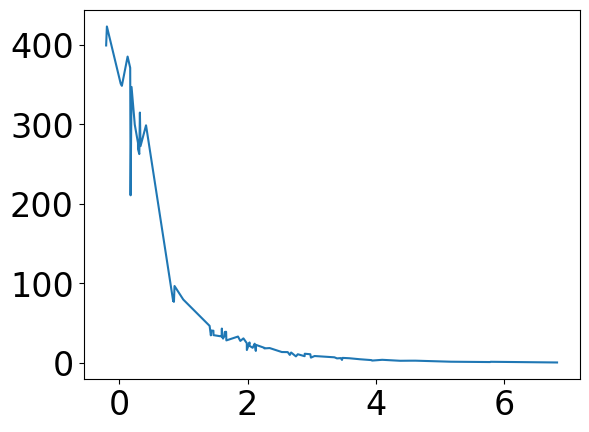

In [184]:
plt.plot(x_sorted, y_sorted)

In [175]:
y_data

array([3.70909852e+02, 4.22908125e+02, 3.50916607e+02, 3.85081209e+02,
       2.62461545e+02, 2.98622596e+02, 3.99046516e+02, 3.48272155e+02,
       3.46851928e+02, 2.68696038e+02, 2.72443455e+02, 2.99372467e+02,
       2.76378556e+02, 3.14635571e+02, 2.10606083e+02, 7.73968835e+01,
       7.66833350e+01, 8.14371022e+01, 9.65112481e+01, 7.94712373e+01,
       4.04835101e+01, 3.33315932e+01, 4.63881797e+01, 3.89532717e+01,
       2.26553930e+01, 3.44738427e+01, 3.07727168e+01, 3.81903941e+01,
       3.87248364e+01, 1.80647597e+01, 3.47215117e+01, 3.21410058e+01,
       4.03038407e+01, 3.29609028e+01, 1.88492688e+01, 3.03350362e+01,
       2.45593435e+01, 3.34034981e+01, 3.06431415e+01, 1.28846924e+01,
       1.59877496e+01, 1.34766363e+01, 2.12394300e+01, 1.84708652e+01,
       6.84642018e+00, 1.48969983e+01, 1.06962064e+01, 1.87997296e+01,
       1.33815198e+01, 5.66892719e+00, 2.80922939e+01, 2.24889641e+01,
       3.25757844e+01, 2.55453518e+01, 1.13441127e+01, 8.01360310e+00,
      

In [173]:
y_fit

array([79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44683346,
       79.44683346, 79.44683346, 79.44683346, 79.44683346, 79.44

<AxesSubplot:xlabel='x', ylabel='y'>

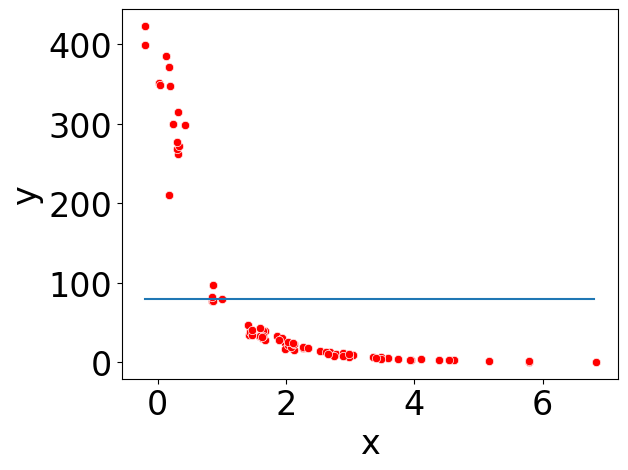

In [172]:
plt.plot(eval_x, y_fit)
sns.scatterplot(data=_s,  x='x', y='y', color='red') 


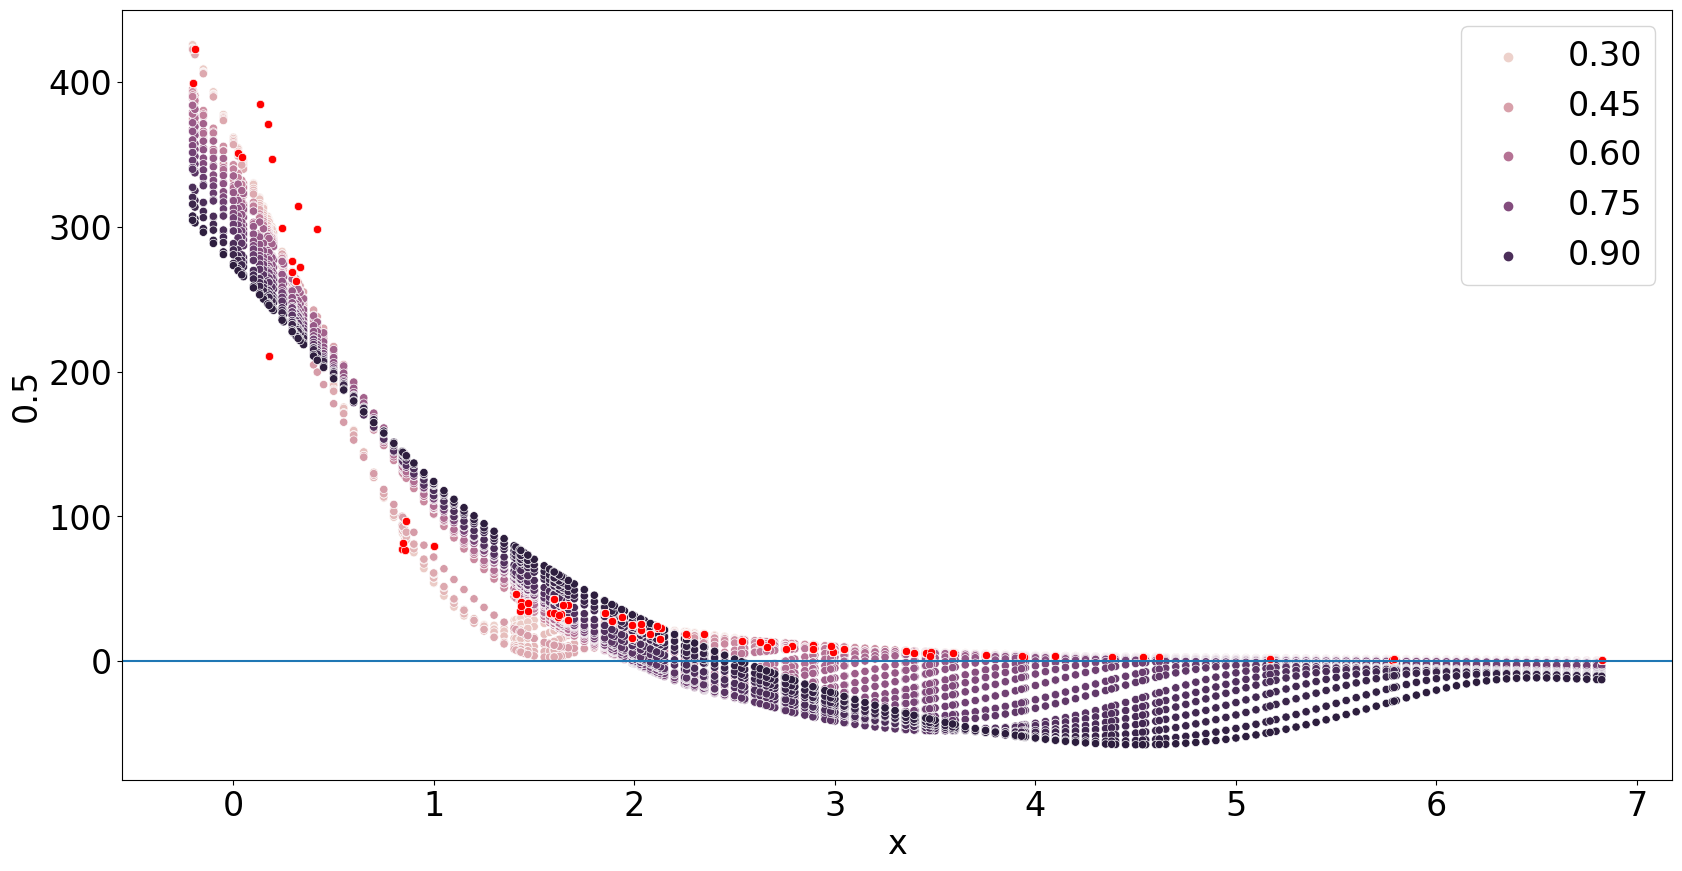